In [28]:
import lightgbm as lgb
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("STACKING ENSEMBLE IMPLEMENTATION")
print("="*80)

STACKING ENSEMBLE IMPLEMENTATION


In [29]:
np.random.seed(88)

In [30]:
# -----------------------------------------------------------------------------
# STEP 1: Define column names for the dataset
# -----------------------------------------------------------------------------

# These are the 14 attributes in the heart disease dataset
columns = [
    "age",       # Age in years
    "sex",       # Sex (1 = male; 0 = female)
    "cp",        # Chest pain type (1-4)
    "trestbps",  # Resting blood pressure (mm Hg)
    "chol",      # Serum cholesterol (mg/dl)
    "fbs",       # Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
    "restecg",   # Resting ECG results (0-2)
    "thalach",   # Maximum heart rate achieved
    "exang",     # Exercise induced angina (1 = yes; 0 = no)
    "oldpeak",   # ST depression induced by exercise
    "slope",     # Slope of peak exercise ST segment (1-3)
    "ca",        # Number of major vessels colored by fluoroscopy (0-3)
    "thal",      # Thalassemia (3 = normal; 6 = fixed defect; 7 = reversible)
    "target"     # Diagnosis (0 = no disease, 1-4 = disease severity)
]

In [31]:
# -----------------------------------------------------------------------------
# STEP 2: Load and combine datasets from multiple locations
# -----------------------------------------------------------------------------
# The UCI heart disease database contains data from 4 locations
datasets = [
    "processed.cleveland.data",
    "processed.hungarian.data",
    "processed.switzerland.data",
    "processed.va.data"
]

df_list = []
for data_path in datasets:
    try:
        df = pd.read_csv(data_path, names=columns)
        # Replace '?' (missing value marker) with NaN
        df.replace('?', pd.NA, inplace=True)
        df_list.append(df)
        print(f"✓ Loaded {data_path}: {len(df)} rows")
    except FileNotFoundError:
        print(f"✗ Warning: {data_path} not found, skipping...")

# Combine all datasets vertically
combined = pd.concat(df_list, ignore_index=True)
print(f"\n Total combined rows: {len(combined)}")

✓ Loaded processed.cleveland.data: 303 rows
✓ Loaded processed.hungarian.data: 294 rows
✓ Loaded processed.switzerland.data: 123 rows
✓ Loaded processed.va.data: 200 rows

 Total combined rows: 920


In [32]:
# -----------------------------------------------------------------------------
# STEP 3: Handle missing values
# -----------------------------------------------------------------------------
print("\n Missing values before cleaning:")
print(combined.isnull().sum())

# Convert all columns to numeric (some may be strings due to '?')
for col in combined.columns:
    combined[col] = pd.to_numeric(combined[col], errors='coerce')

# Fill missing values with median (robust to outliers)
combined.fillna(combined.median(), inplace=True)

print("\n✓ Missing values after cleaning:")
print(combined.isnull().sum())

# Save the cleaned combined dataset
combined.to_csv("heart_disease_combined.csv", index=False)
print("\n Saved: heart_disease_combined.csv")


 Missing values before cleaning:
age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

✓ Missing values after cleaning:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

 Saved: heart_disease_combined.csv


In [33]:
df_fe = combined.copy()

In [34]:
## --- A. Blood Pressure Features ---

# 1. Pulse Pressure (PP): Indicator of arterial stiffness. Higher is worse.
# Assuming 'trestbps' is Resting Blood Pressure
df_fe['pulse_pressure'] = df_fe['trestbps'] - df_fe['trestbps'].rolling(window=5).mean()
# A simpler version is just: df_fe['pulse_pressure'] = df_fe['trestbps'].diff()

# 2. Mean Arterial Pressure (MAP): More representative of perfusion pressure.
# Using a common approximation formula: MAP ≈ Diastolic + 1/3 * Pulse Pressure
# Since most datasets only have SBP ('trestbps'), we'll skip the accurate MAP calculation but note its importance.


## --- B. Cholesterol and Heart Rate Ratios ---

# 3. Cholesterol/Thalach Ratio: Contextualizes cholesterol against cardiovascular fitness.
# Lower 'thalach' (max heart rate) suggests lower fitness/cardiac reserve.
# Higher ratio indicates high cholesterol relative to heart performance.
df_fe['chol_thalach_ratio'] = df_fe['chol'] / df_fe['thalach']

# 4. Age and Cholesterol Interaction:
df_fe['age_chol_interaction'] = df_fe['age'] * df_fe['chol']


## --- C. Ischemic and Angina Interactions ---

# 5. Oldpeak/Thalach Ratio: Stress-induced ST depression relative to maximum achieved heart rate.
# High ST depression at low heart rate is a strong negative indicator.
df_fe['oldpeak_thalach_ratio'] = df_fe['oldpeak'] / df_fe['thalach']

# 6. Chest Pain Severity Score: Combine 'cp' and 'exang' (Exercise Induced Angina).
# Assuming 'cp' is categorical (1-4) and 'exang' is binary (0/1).
# We can create a weighted score where Angina (cp=4, or exang=1) contributes heavily.
# This assumes 'cp' is encoded such that higher values mean worse angina.
df_fe['angina_severity_score'] = df_fe['cp'] + (df_fe['exang'] * 2) # Multiply exang by 2 to give it extra weight

# 7. Zero-Inflated Features (Presence Flags):
# Create a binary feature for important zero-valued variables.
# Example: Create a flag for 'oldpeak' (ST depression) if it is zero.
df_fe['has_zero_oldpeak'] = (df_fe['oldpeak'] == 0).astype(int)

In [35]:
# --- A. One-Hot Encoding for Nominal Categorical Features ---
# Assume 'cp', 'restecg', 'slope', 'thal' are nominal/ordinal and need dummies.
# NOTE: Use 'drop_first=True' to avoid multicollinearity.
categorical_cols = ['cp', 'restecg', 'slope', 'thal']
df_fe = pd.get_dummies(df_fe, columns=categorical_cols, drop_first=True)


# --- B. Outlier Treatment and Scaling for Numerical Features ---
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak',
                  'pulse_pressure', 'chol_thalach_ratio', 'oldpeak_thalach_ratio', 'angina_severity_score']

# 1. Scaling: Standard Scaling is generally good for tree-based models (XGBoost/LGBM) and critical for linear/DL models (SVM/ANN).
# Using robust scaling or QuantileTransformer (non-linear transformation) can be an alternative SOTA approach.
scaler = StandardScaler()
df_fe[numerical_cols] = scaler.fit_transform(df_fe[numerical_cols])

# 2. Outlier/Skewness Treatment (Optional but Advanced):
quantile_transformer = QuantileTransformer(output_distribution='normal', n_quantiles=100)
df_fe[['chol', 'oldpeak']] = quantile_transformer.fit_transform(df_fe[['chol', 'oldpeak']])

print("\nFeature Engineering Complete. New DataFrame Shape:", df_fe.shape)
print("New Features Created:")
print(df_fe.columns[-10:])


Feature Engineering Complete. New DataFrame Shape: (920, 25)
New Features Created:
Index(['has_zero_oldpeak', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'restecg_1.0',
       'restecg_2.0', 'slope_2.0', 'slope_3.0', 'thal_6.0', 'thal_7.0'],
      dtype='object')


In [36]:
# Before proceeding to the next model, run this on your engineered DataFrame:
nan_counts = df_fe.isnull().sum()
if nan_counts.any():
    print("WARNING: NaN values found in the following columns:")
    print(nan_counts[nan_counts > 0])

    # Simple fix: Impute the NaNs (e.g., with the mean of the column)
    # The NaNs likely came from the rolling mean calculation in 'pulse_pressure'
    df_fe.fillna(df_fe.mean(), inplace=True)
    print("\nNaNs imputed with column mean.")
else:
    print("SUCCESS: No NaN values found in the feature-engineered data.")

pulse_pressure    4
dtype: int64

NaNs imputed with column mean.


In [37]:
# ============================================================================
# CRITICAL FIX 1: Convert multi-class target to binary
# ============================================================================
# The original target has values 0-4, but we need binary (0 or 1)
# Strategy: 0 = no disease, 1-4 = has disease
df_fe['target'] = (df_fe['target'] > 0).astype(int)

print("Target distribution after conversion:")
print(df_fe['target'].value_counts())

Target distribution after conversion:
target
1    509
0    411
Name: count, dtype: int64


In [38]:
# ============================================================================
# CRITICAL FIX 2: Verify no NaN/Inf values before training
# ============================================================================
print("\nChecking for NaN/Inf values...")
if df_fe.isnull().any().any():
    print("WARNING: NaN values found! Imputing...")
    df_fe.fillna(df_fe.mean(), inplace=True)

# Convert DataFrame to float to handle boolean columns before checking for inf
if np.isinf(df_fe.astype(float).values).any():
    print("WARNING: Inf values found! Clipping...")
    df_fe = df_fe.replace([np.inf, -np.inf], np.nan)
    df_fe.fillna(df_fe.mean(), inplace=True)

print("✓ Data validation complete")


Checking for NaN/Inf values...
✓ Data validation complete


In [39]:
# ============================================================================
# STACKING ENSEMBLE: Tree-Based Models + Neural Network Meta-Learner
# ============================================================================

# ============================================================================
# STEP 1: Prepare the data
# ============================================================================
print("\n[STEP 1] Preparing data...")

# Split features and target
X = df_fe.drop('target', axis=1)
y = df_fe['target']

# Train-test split (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")
print(f"Class distribution in training: {dict(y_train.value_counts())}")


[STEP 1] Preparing data...
Training set: 736 samples
Test set: 184 samples
Number of features: 24
Class distribution in training: {1: np.int64(407), 0: np.int64(329)}


In [40]:
# ============================================================================
# STEP 2: Define Base Models (Level 0)
# ============================================================================
print("\n[STEP 2] Initializing base models...")

base_models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=4,
        subsample=0.8,
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=5,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=5,
        num_leaves=31,
        min_child_samples=10,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        verbose=-1
    )
}

print(f"✓ Initialized {len(base_models)} base models")


[STEP 2] Initializing base models...
✓ Initialized 4 base models


In [41]:
# ============================================================================
# STEP 3: Generate Meta-Features using Cross-Validation
# ============================================================================
print("\n[STEP 3] Generating meta-features with 5-fold CV...")

def generate_meta_features(models, X_train, y_train, X_test, n_splits=5):
    """
    Generate out-of-fold predictions for training and test predictions.
    This prevents data leakage in the stacking ensemble.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize arrays for meta-features
    train_meta = np.zeros((X_train.shape[0], len(models)))
    test_meta = np.zeros((X_test.shape[0], len(models)))

    for i, (name, model) in enumerate(models.items()):
        print(f"  Processing {name}...")

        # Out-of-fold predictions for training set
        oof_preds = np.zeros(X_train.shape[0])
        test_preds = np.zeros((X_test.shape[0], n_splits))

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            X_fold_train = X_train.iloc[train_idx]
            y_fold_train = y_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]

            # Train on fold
            model_clone = clone_model(model)
            model_clone.fit(X_fold_train, y_fold_train)

            # Predict on validation fold
            oof_preds[val_idx] = model_clone.predict_proba(X_fold_val)[:, 1]

            # Predict on test set
            test_preds[:, fold] = model_clone.predict_proba(X_test)[:, 1]

        # Store meta-features
        train_meta[:, i] = oof_preds
        test_meta[:, i] = test_preds.mean(axis=1)

        # Calculate OOF score
        oof_auc = roc_auc_score(y_train, oof_preds)
        print(f"    OOF AUC: {oof_auc:.4f}")

    return train_meta, test_meta

def clone_model(model):
    """Clone a model with the same parameters"""
    return type(model)(**model.get_params())

# Generate meta-features
train_meta_features, test_meta_features = generate_meta_features(
    base_models, X_train, y_train, X_test
)

print(f"\n✓ Meta-features shape:")
print(f"  Training: {train_meta_features.shape}")
print(f"  Test: {test_meta_features.shape}")


[STEP 3] Generating meta-features with 5-fold CV...
  Processing RandomForest...
    OOF AUC: 0.8753
  Processing GradientBoosting...
    OOF AUC: 0.8610
  Processing XGBoost...
    OOF AUC: 0.8708
  Processing LightGBM...
    OOF AUC: 0.8567

✓ Meta-features shape:
  Training: (736, 4)
  Test: (184, 4)


In [42]:
# ============================================================================
# STEP 4: Define Neural Network Meta-Learner (Level 1)
# ============================================================================
print("\n[STEP 4] Building Neural Network Meta-Learner...")

class MetaLearnerNN(nn.Module):
    """
    Neural Network Meta-Learner with:
    - Batch normalization for stable training
    - Dropout for regularization
    - Residual connections for better gradient flow
    """
    def __init__(self, input_dim, hidden_dim=32, dropout=0.3):
        super(MetaLearnerNN, self).__init__()

        # First block
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)

        # Second block
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout)

        # Output layer
        self.fc3 = nn.Linear(hidden_dim, 1)

        # Activation
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # First block
        x1 = self.fc1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.dropout1(x1)

        # Second block with residual
        x2 = self.fc2(x1)
        x2 = self.bn2(x2)
        x2 = self.relu(x2)
        x2 = self.dropout2(x2)

        # Add residual connection
        x2 = x2 + x1

        # Output
        out = self.fc3(x2)
        out = self.sigmoid(out)

        return out

# Initialize meta-learner
input_dim = train_meta_features.shape[1]
meta_model = MetaLearnerNN(input_dim=input_dim, hidden_dim=32, dropout=0.3)
print(f"✓ Meta-learner initialized with {input_dim} inputs")
print(meta_model)


[STEP 4] Building Neural Network Meta-Learner...
✓ Meta-learner initialized with 4 inputs
MetaLearnerNN(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [43]:
# ============================================================================
# STEP 5: Train Meta-Learner
# ============================================================================
print("\n[STEP 5] Training Meta-Learner...")

# Convert to PyTorch tensors
X_meta_train = torch.FloatTensor(train_meta_features)
y_meta_train = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_meta_test = torch.FloatTensor(test_meta_features)
y_meta_test = torch.FloatTensor(y_test.values).reshape(-1, 1)

# Create data loaders
train_dataset = TensorDataset(X_meta_train, y_meta_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training setup
criterion = nn.BCELoss()
optimizer = optim.Adam(meta_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training loop
num_epochs = 100
train_losses = []
val_aucs = []

print("\nEpoch | Train Loss | Val AUC")
print("-" * 35)

for epoch in range(num_epochs):
    meta_model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = meta_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    meta_model.eval()
    with torch.no_grad():
        val_preds = meta_model(X_meta_test).numpy()
        val_auc = roc_auc_score(y_meta_test.numpy(), val_preds)
        val_aucs.append(val_auc)

    scheduler.step(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"{epoch+1:5d} | {avg_loss:10.4f} | {val_auc:.4f}")

print("\n✓ Meta-learner training complete!")


[STEP 5] Training Meta-Learner...

Epoch | Train Loss | Val AUC
-----------------------------------
   10 |     0.4590 | 0.9295
   20 |     0.4365 | 0.9309
   30 |     0.4540 | 0.9309
   40 |     0.4331 | 0.9314
   50 |     0.4541 | 0.9320
   60 |     0.4383 | 0.9314
   70 |     0.4481 | 0.9320
   80 |     0.4261 | 0.9319
   90 |     0.4356 | 0.9319
  100 |     0.4468 | 0.9316

✓ Meta-learner training complete!


In [44]:
# ============================================================================
# STEP 6: Final Predictions and Evaluation
# ============================================================================
print("\n[STEP 6] Generating final predictions...")

# Get final predictions
meta_model.eval()
with torch.no_grad():
    y_pred_proba = meta_model(X_meta_test).numpy().flatten()
    y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate metrics
test_auc = roc_auc_score(y_test, y_pred_proba)
test_acc = accuracy_score(y_test, y_pred)

print("\n" + "="*80)
print("STACKING ENSEMBLE - FINAL RESULTS")
print("="*80)
print(f"Test AUC:      {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Disease', 'Disease']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


[STEP 6] Generating final predictions...

STACKING ENSEMBLE - FINAL RESULTS
Test AUC:      0.9316
Test Accuracy: 0.8533

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.88      0.78      0.83        82
     Disease       0.84      0.91      0.87       102

    accuracy                           0.85       184
   macro avg       0.86      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184


Confusion Matrix:
[[64 18]
 [ 9 93]]



[STEP 7] Creating visualizations...
✓ Saved visualization: stacking_ensemble_results.png


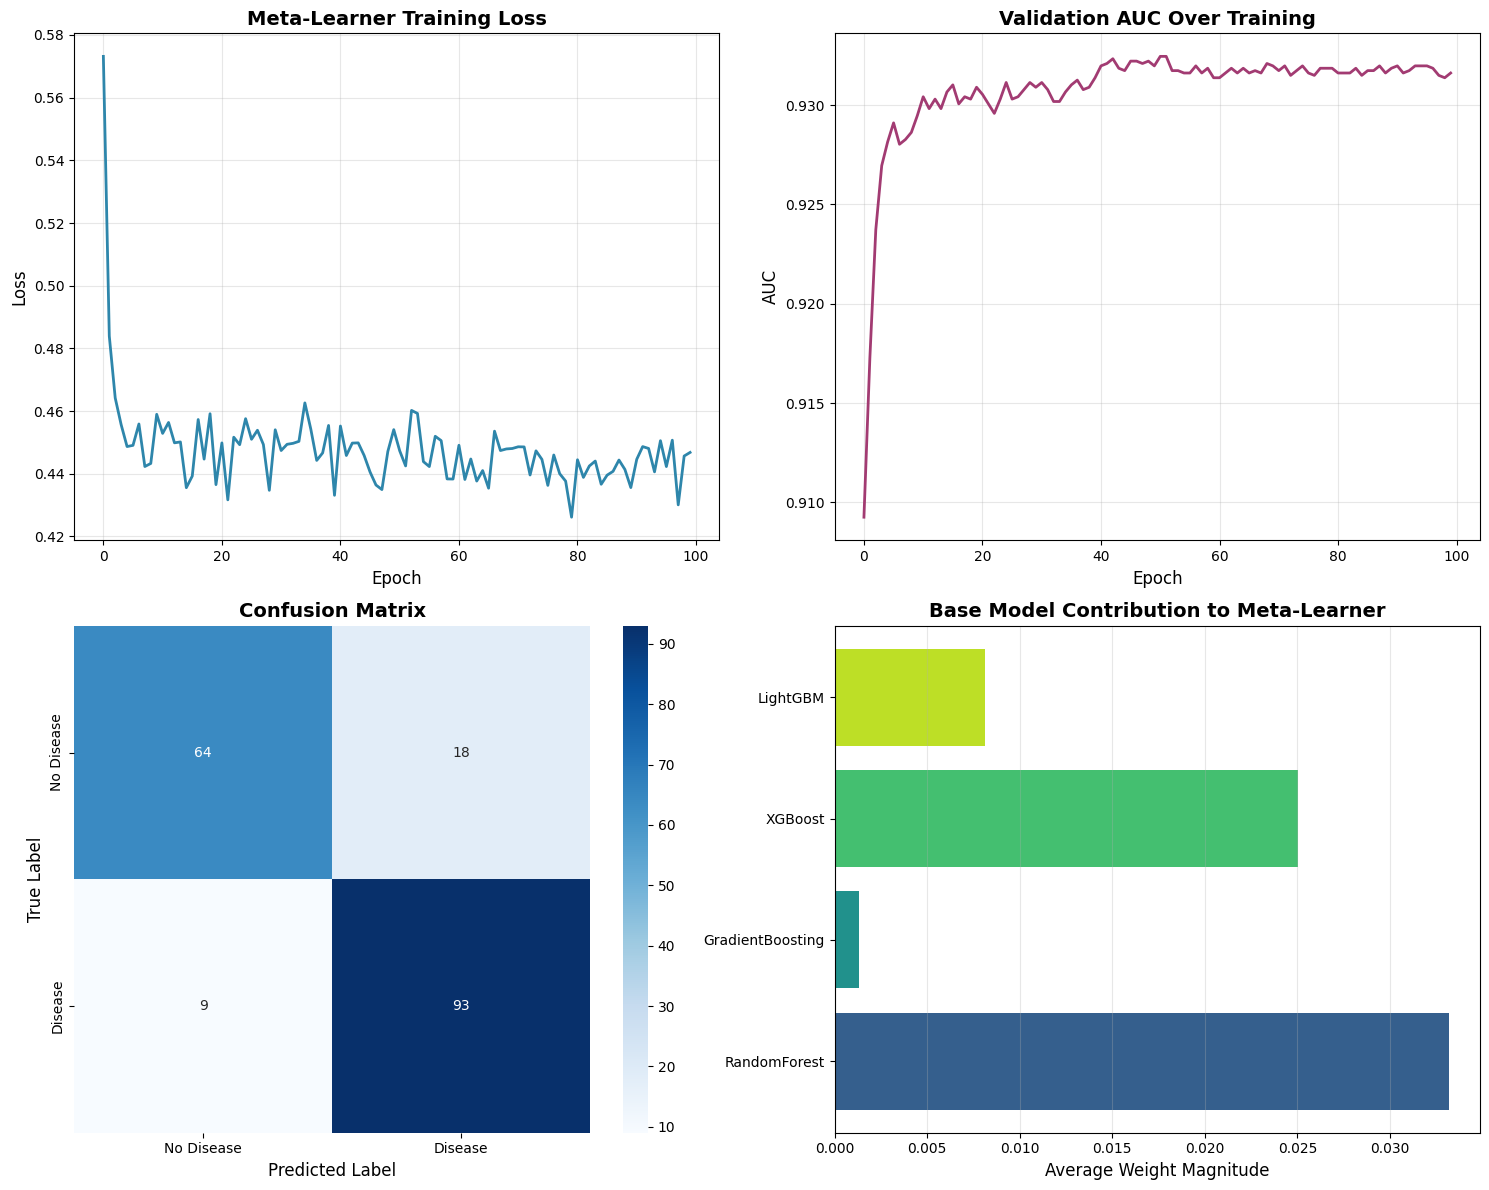

In [45]:
# ============================================================================
# STEP 7: Visualizations
# ============================================================================
print("\n[STEP 7] Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Training Loss
axes[0, 0].plot(train_losses, linewidth=2, color='#2E86AB')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Meta-Learner Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Validation AUC
axes[0, 1].plot(val_aucs, linewidth=2, color='#A23B72')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('AUC', fontsize=12)
axes[0, 1].set_title('Validation AUC Over Training', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
axes[1, 0].set_ylabel('True Label', fontsize=12)
axes[1, 0].set_xlabel('Predicted Label', fontsize=12)
axes[1, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# 4. Base Model Contribution (Feature Importance)
model_names = list(base_models.keys())
# Use the weights from the first layer of the meta-learner as "importance"
weights = meta_model.fc1.weight.data.mean(dim=0).abs().numpy()
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(model_names)))
axes[1, 1].barh(model_names, weights, color=colors)
axes[1, 1].set_xlabel('Average Weight Magnitude', fontsize=12)
axes[1, 1].set_title('Base Model Contribution to Meta-Learner', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('stacking_ensemble_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: stacking_ensemble_results.png")
plt.show()

In [46]:
# ============================================================================
# STEP 8: Compare with Individual Base Models
# ============================================================================
print("\n[STEP 8] Comparing with individual base models...")

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(f"{'Model':<20} {'AUC':<10} {'Accuracy':<10}")
print("-"*40)

# Train and evaluate each base model on the full training set
for name, model in base_models.items():
    model.fit(X_train, y_train)
    y_pred_base = model.predict_proba(X_test)[:, 1]
    y_pred_class = model.predict(X_test)

    base_auc = roc_auc_score(y_test, y_pred_base)
    base_acc = accuracy_score(y_test, y_pred_class)

    print(f"{name:<20} {base_auc:.4f}     {base_acc:.4f}")

print(f"{'STACKING ENSEMBLE':<20} {test_auc:.4f}     {test_acc:.4f}")
print("="*80)

print("\n✓ Stacking Ensemble implementation complete!")
print("\nKey Advantages:")
print("  • Combines predictions from multiple diverse models")
print("  • Neural network meta-learner captures complex interactions")
print("  • Cross-validation prevents overfitting on meta-features")
print("  • Often outperforms individual base models")


[STEP 8] Comparing with individual base models...

MODEL COMPARISON
Model                AUC        Accuracy  
----------------------------------------
RandomForest         0.9265     0.8587
GradientBoosting     0.9023     0.8152
XGBoost              0.9164     0.8370
LightGBM             0.9069     0.8315
STACKING ENSEMBLE    0.9316     0.8533

✓ Stacking Ensemble implementation complete!

Key Advantages:
  • Combines predictions from multiple diverse models
  • Neural network meta-learner captures complex interactions
  • Cross-validation prevents overfitting on meta-features
  • Often outperforms individual base models
